In [2]:
from hicmatrix import HiCMatrix as hm
from hicmatrix.lib import MatrixFileHandler
import numpy as np
import pandas as pd
from scipy import stats, sparse
import bottleneck
from scipy.stats import mannwhitneyu
import h5py
import h5py
import logging
import numpy as np
import pandas as pd
from hicmatrix import HiCMatrix as hm
from hicmatrix.lib import MatrixFileHandler
from scipy.sparse import csr_matrix, dia_matrix, triu, tril, coo_matrix
import scipy.stats as stats
import os.path
import gc
import os
import seaborn as sns
%matplotlib inline

INFO:numexpr.utils:Note: detected 192 virtual cores but NumExpr set to maximum of 64, check "NUMEXPR_MAX_THREADS" environment variable.
INFO:numexpr.utils:Note: NumExpr detected 192 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


In [2]:
process_type='inter'

species='human'
SRP_name='aggregates'
resolution='1kbp_raw'

In [3]:
with h5py.File(f'/grid/gillis/data/lohia/hi_c_data_processing/data_{species}/{SRP_name}/{resolution}/max/contact_top1/hic_gene_{process_type}_none_by_allbins_top1.h5', 'r') as hf:
    my_data = hf['matrix'][:]
    gene_list = hf['gene_list'][:]

    bins_bed = hf['bins_bed'][:]

In [427]:
with h5py.File(f'/grid/gillis/data/lohia/hi_c_data_processing/data_{species}/{SRP_name}/{resolution}/max/contact_top1/hic_gene_{process_type}_none_by_allbins_top1.h5', 'r') as hf:

    gene_list = hf['gene_list'][:]

    bins_bed = hf['bins_bed'][:]

In [4]:
number_of_genes_list = [10, 50, 100, 150, 200, 250, 500, 1000]
marker_level_list = ['class', 'subclass', 'type']

number_of_genes_list = [100]
marker_level_list = ['type']

for number_of_genes in number_of_genes_list:
    for marker_level in marker_level_list:


        marker_list = pd.read_csv(f'/grid/gillis/data/lohia/hi_c_data_processing/notebooks/metamarkers/human/{marker_level}_markers_top1000.csv.gz', skiprows=1)

        marker_list['gene'] = marker_list['gene'].str.upper()
        df_ensg_name = pd.read_csv('/grid/gillis/data/lohia/hi_c_data_processing/genomes_jlee/ensg_geneid_symbol.csv', sep='\t')[['Ensembl_gene_identifier', 'Symbol']]
        marker_list = marker_list.merge(df_ensg_name.drop_duplicates(), right_on='Symbol', left_on='gene') 
        marker_list = marker_list[marker_list['Ensembl_gene_identifier'].isin([x.decode() for x in gene_list])]
        
        all_cell_types = marker_list.drop_duplicates(['cell_type'])['cell_type'].tolist()
        df2_list = []



        for group2 in all_cell_types:
            df2_list.append(marker_list[marker_list['cell_type']==group2].sort_values(by=['rank']).head(number_of_genes))
            #marker_list['cell_type'] =   marker_list['cell_type'].sample(frac = 1).values
            #df2_list.append(marker_list[marker_list['cell_type']==group2].sort_values(by=['rank']).tail(number_of_genes))
            #print ((marker_list[marker_list['cell_type']==group2].sort_values(by=['rank']).head(number_of_genes)).shape[0])
        marker_list=pd.concat(df2_list)
        #marker_list = marker_list[marker_list['rank'] <= number_of_genes] 
        
        #marker_list = marker_list[marker_list['auroc'] >= 0.85] 
        #marker_list = marker_list[marker_list.group.isin(['Sst'])]

        #marker_list = marker_list[marker_list.cell_type.isin(['Pvalb_1', 'Pvalb_2'])]
        #marker_list = marker_list.drop_duplicates(subset=['gene'], keep=False)
                
        #m_number_of_genes = number_of_genes +20
        #marker_list = marker_list[marker_list['rank'] < m_number_of_genes]
        #marker_list = marker_list.sort_values(by=['rank'])
        #print (marker_list)
        marker_list = marker_list.sort_values(by='rank').drop_duplicates(subset=['Ensembl_gene_identifier'])
        
        marker_table = marker_list.pivot_table(index='Ensembl_gene_identifier', columns='cell_type', values='rank', aggfunc='sum')

        marker_table.fillna(0, inplace=True)

        marker_table[marker_table != 0] = 1

/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [5]:
if marker_level == 'type':

    marker_list_t = pd.read_csv('/grid/gillis/data/lohia/hi_c_data_processing/notebooks/metamarkers/human/subclass_markers_top1000.csv.gz', skiprows=1)

    marker_list_t = marker_list_t.drop_duplicates(subset='cell_type')

    marker_list_t.rename(columns = {'group':'classt'}, inplace = True)
    marker_list_t.rename(columns = {'cell_type':'group'}, inplace = True)


    marker_list = marker_list[['Ensembl_gene_identifier', 'group', 'cell_type']].merge(marker_list_t[['classt', 'group']])
    
if marker_level == 'subclass':
    marker_list.rename(columns = {'group':'classt'}, inplace = True)
    marker_list.rename(columns = {'cell_type':'group'}, inplace = True)
    marker_list['cell_type'] = marker_list['group'].tolist()
    

In [6]:
marker_list = marker_list.sample(frac=1)

marker_list = marker_list[['classt', 'group', 'cell_type', 'Ensembl_gene_identifier']]

In [7]:
df_gene_tp = pd.DataFrame(my_data ,  index=[x.decode() for x in gene_list.tolist()], columns = bins_bed.tolist())


df_gene_tp = df_gene_tp.loc[marker_list['Ensembl_gene_identifier'].tolist(), :]

#df_gene_tp = df_gene_tp.fillna(0)

In [8]:
df_gene_tp_all_info = df_gene_tp.merge(marker_list, left_on=df_gene_tp.index, right_on=marker_list['Ensembl_gene_identifier'])

df_gene_tp_all_info = df_gene_tp_all_info.set_index('key_0')

df_gene_tp_all_info = df_gene_tp_all_info.drop(columns=['Ensembl_gene_identifier'])

#df_gene_tp_all_info_mean = df_gene_tp_all_info.groupby(['classt','group', 'cell_type']).mean()
df_gene_tp_all_info_mean = df_gene_tp_all_info.groupby(['classt','group']).mean()

In [16]:
all_bins_mean = df_gene_tp_all_info_mean.mean(axis=0)

all_bins_std = df_gene_tp_all_info_mean.std(axis=0)

In [434]:
df_gene_tp_all_info_mean

0        1        2        3        \
classt        group      cell_type                                        
GABAergic     Chandelier Chandelier      0.0      0.0      0.0      0.0   
              Lamp5      Lamp5           0.0      0.0      0.0      0.0   
              Lamp5_Lhx6 Lamp5_Lhx6      0.0      0.0      0.0      0.0   
              Pax6       Pax6            0.0      0.0      0.0      0.0   
              Pvalb      Pvalb           0.0      0.0      0.0      0.0   
              Sncg       Sncg            0.0      0.0      0.0      0.0   
              Sst        Sst             0.0      0.0      0.0      0.0   
              Sst Chodl  Sst Chodl       0.0      0.0      0.0      0.0   
              Vip        Vip             0.0      0.0      0.0      0.0   
Glutamatergic L2/3 IT    L2/3 IT         0.0      0.0      0.0      0.0   
              L4 IT      L4 IT           0.0      0.0      0.0      0.0   
              L5 ET      L5 ET           0.0      0.0      0.0      0.0   
              L5 IT      L5 IT           0.0      0.0      0.0      0.0   
              L5/6 NP    L5/6 NP         0.0      0.0      0.0      0.0   
              L6 CT      L6 CT           0.0      0.0      0.0      0.0   
              L6 IT      L6 IT           0.0      0.0      0.0      0.0   
              L6 IT Car3 L6 IT Car3      0.0      0.0      0.0      0.0   
              L6b        L6b             0.0      0.0      0.0      0.0   
Non-neuronal  Astro      Astro           0.0      0.0      0.0      0.0   
              Endo       Endo            0.0      0.0      0.0      0.0   
              Micro-PVM  Micro-PVM       0.0      0.0      0.0      0.0   
              OPC        OPC             0.0      0.0      0.0      0.0   
              Oligo      Oligo           0.0      0.0      0.0      0.0   
              VLMC       VLMC            0.0      0.0      0.0      0.0   

                                     4        5        6        7        \
classt        group      cell_type                                        
GABAergic     Chandelier Chandelier      0.0      0.0      0.0      0.0   
              Lamp5      Lamp5           0.0      0.0      0.0      0.0   
              Lamp5_Lhx6 Lamp5_Lhx6      0.0      0.0      0.0      0.0   
              Pax6       Pax6            0.0      0.0      0.0      0.0   
              Pvalb      Pvalb           0.0      0.0      0.0      0.0   
              Sncg       Sncg            0.0      0.0      0.0      0.0   
              Sst        Sst             0.0      0.0      0.0      0.0   
              Sst Chodl  Sst Chodl       0.0      0.0      0.0      0.0   
              Vip        Vip             0.0      0.0      0.0      0.0   
Glutamatergic L2/3 IT    L2/3 IT         0.0      0.0      0.0      0.0   
              L4 IT      L4 IT           0.0      0.0      0.0      0.0   
              L5 ET      L5 ET           0.0      0.0      0.0      0.0   
              L5 IT      L5 IT           0.0      0.0      0.0      0.0   
              L5/6 NP    L5/6 NP         0.0      0.0      0.0      0.0   
              L6 CT      L6 CT           0.0      0.0      0.0      0.0   
              L6 IT      L6 IT           0.0      0.0      0.0      0.0   
              L6 IT Car3 L6 IT Car3      0.0      0.0      0.0      0.0   
              L6b        L6b             0.0      0.0      0.0      0.0   
Non-neuronal  Astro      Astro           0.0      0.0      0.0      0.0   
              Endo       Endo            0.0      0.0      0.0      0.0   
              Micro-PVM  Micro-PVM       0.0      0.0      0.0      0.0   
              OPC        OPC             0.0      0.0      0.0      0.0   
              Oligo      Oligo           0.0      0.0      0.0      0.0   
              VLMC       VLMC            0.0      0.0      0.0      0.0   

                                     8        9        ...  2875002  2875003  \
classt        group      cell_type                     

In [11]:
lut = dict(zip( df_gene_tp_all_info_mean.index.get_level_values('classt').drop_duplicates(), sns.color_palette("Set1", df_gene_tp_all_info_mean.index.get_level_values('classt').shape[0]).as_hex()[:]))


row_colors =df_gene_tp_all_info_mean.index.get_level_values('classt').map(lut)

lut = dict(zip( df_gene_tp_all_info_mean.index.get_level_values('group').drop_duplicates(), sns.color_palette("Paired", df_gene_tp_all_info_mean.index.get_level_values('group').shape[0]).as_hex()[:]))
row_colors2 =df_gene_tp_all_info_mean.index.get_level_values('group').map(lut)

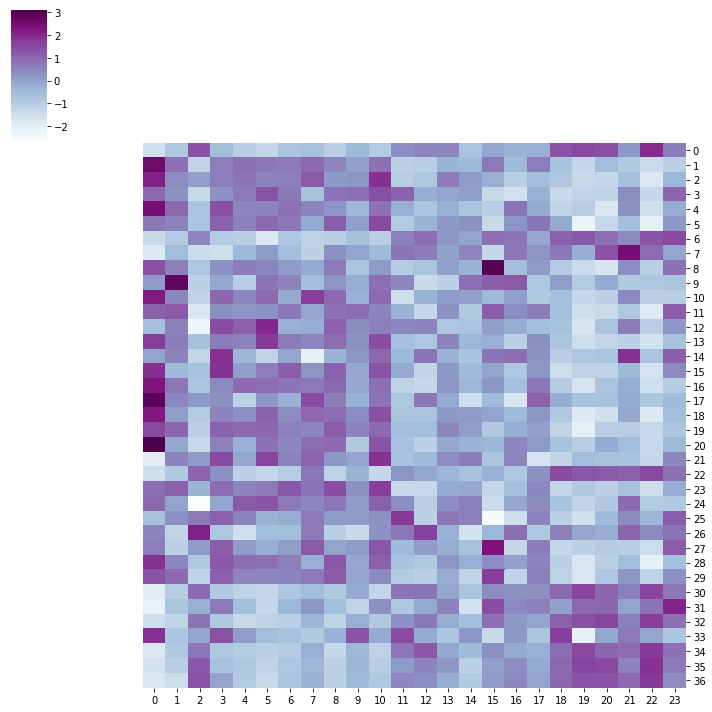

In [12]:
df_hba_modules = pd.read_csv(f'/grid/gillis/data/lohia/hi_c_data_processing/data_human/{SRP_name}/{resolution}/cre_modules.bed', sep='\t', names=['c','d', 'e', 'f', 'ccre', 'chr', 'start', 'end', 'bin_id'])


df_hba_modules = df_hba_modules.drop_duplicates(['bin_id'], keep=False)
all_bins = []
mean_list = []
for i in list(range(1,38)):
    m="M"+str(i)
    given_bins = df_hba_modules[df_hba_modules['ccre']==m]['bin_id'].tolist()
    all_bins.extend(given_bins)
    mean_list.append(df_gene_tp_all_info_mean.loc[: , given_bins].mean(axis=1).values.tolist())
    
sns.clustermap(np.vstack(mean_list), cmap="BuPu", col_cluster=False, row_cluster=False, robust=False, z_score=0)


In [15]:
df_gene_tp_all_info_mean

0        1        2        3        4        \
classt        group                                                     
GABAergic     Chandelier      0.0      0.0      0.0      0.0      0.0   
              Lamp5           0.0      0.0      0.0      0.0      0.0   
              Lamp5_Lhx6      0.0      0.0      0.0      0.0      0.0   
              Pax6            0.0      0.0      0.0      0.0      0.0   
              Pvalb           0.0      0.0      0.0      0.0      0.0   
              Sncg            0.0      0.0      0.0      0.0      0.0   
              Sst             0.0      0.0      0.0      0.0      0.0   
              Sst Chodl       0.0      0.0      0.0      0.0      0.0   
              Vip             0.0      0.0      0.0      0.0      0.0   
Glutamatergic L2/3 IT         0.0      0.0      0.0      0.0      0.0   
              L4 IT           0.0      0.0      0.0      0.0      0.0   
              L5 ET           0.0      0.0      0.0      0.0      0.0   
              L5 IT           0.0      0.0      0.0      0.0      0.0   
              L5/6 NP         0.0      0.0      0.0      0.0      0.0   
              L6 CT           0.0      0.0      0.0      0.0      0.0   
              L6 IT           0.0      0.0      0.0      0.0      0.0   
              L6 IT Car3      0.0      0.0      0.0      0.0      0.0   
              L6b             0.0      0.0      0.0      0.0      0.0   
Non-neuronal  Astro           0.0      0.0      0.0      0.0      0.0   
              Endo            0.0      0.0      0.0      0.0      0.0   
              Micro-PVM       0.0      0.0      0.0      0.0      0.0   
              OPC             0.0      0.0      0.0      0.0      0.0   
              Oligo           0.0      0.0      0.0      0.0      0.0   
              VLMC            0.0      0.0      0.0      0.0      0.0   

                          5        6        7        8        9        ...  \
classt        group                                                    ...   
GABAergic     Chandelier      0.0      0.0      0.0      0.0      0.0  ...   
              Lamp5           0.0      0.0      0.0      0.0      0.0  ...   
              Lamp5_Lhx6      0.0      0.0      0.0      0.0      0.0  ...   
              Pax6            0.0      0.0      0.0      0.0      0.0  ...   
              Pvalb           0.0      0.0      0.0      0.0      0.0  ...   
              Sncg            0.0      0.0      0.0      0.0      0.0  ...   
              Sst             0.0      0.0      0.0      0.0      0.0  ...   
              Sst Chodl       0.0      0.0      0.0      0.0      0.0  ...   
              Vip             0.0      0.0      0.0      0.0      0.0  ...   
Glutamatergic L2/3 IT         0.0      0.0      0.0      0.0      0.0  ...   
              L4 IT           0.0      0.0      0.0      0.0      0.0  ...   
              L5 ET           0.0      0.0      0.0      0.0      0.0  ...   
              L5 IT           0.0      0.0      0.0      0.0      0.0  ...   
              L5/6 NP         0.0      0.0      0.0      0.0      0.0  ...   
              L6 CT           0.0      0.0      0.0      0.0      0.0  ...   
              L6 IT           0.0      0.0      0.0      0.0      0.0  ...   
              L6 IT Car3      0.0      0.0      0.0      0.0      0.0  ...   
              L6b             0.0      0.0      0.0      0.0      0.0  ...   
Non-neuronal  Astro           0.0      0.0      0.0      0.0      0.0  ...   
              Endo            0.0      0.0      0.0      0.0      0.0  ...   
              Micro-PVM       0.0      0.0      0.0      0.0      0.0  ...   
              OPC             0.0      0.0      0.0      0.0      0.0  ...   
              Oligo           0.0      0.0      0.0      0.0      0.0  ...   
              VLMC            0.0      0.0      0.0      0.0      0.0  ...   

                          2875002  2875003  2875004  2875005  2875006  \
classt        group      

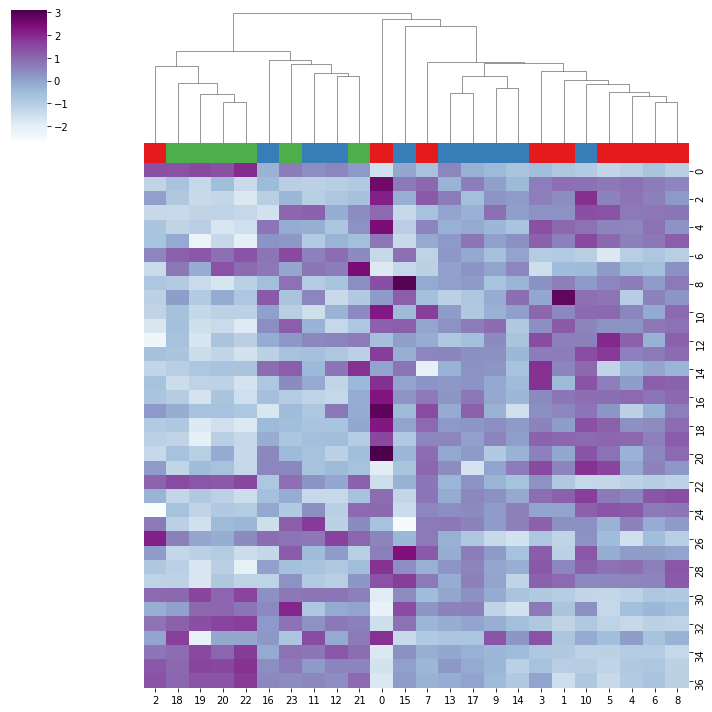

In [13]:
sns.clustermap(np.vstack(mean_list), cmap="BuPu", col_cluster=True, row_cluster=False, robust=False, z_score=0, col_colors=[row_colors])


In [1]:
from umap import UMAP
import plotly.express as px




#features = df.loc[:, :2875001]
features = np.vstack(mean_list).T


umap_2d = UMAP(n_components=2, init='random', random_state=0)


proj_2d = umap_2d.fit_transform(features)
fig_2d = px.scatter(
    proj_2d, x=0, y=1,
    color=df_gene_tp_all_info_mean.index.get_level_values('classt'), labels={'color': 'classt'}
)


fig_2d.show()

NameError: name 'np' is not defined

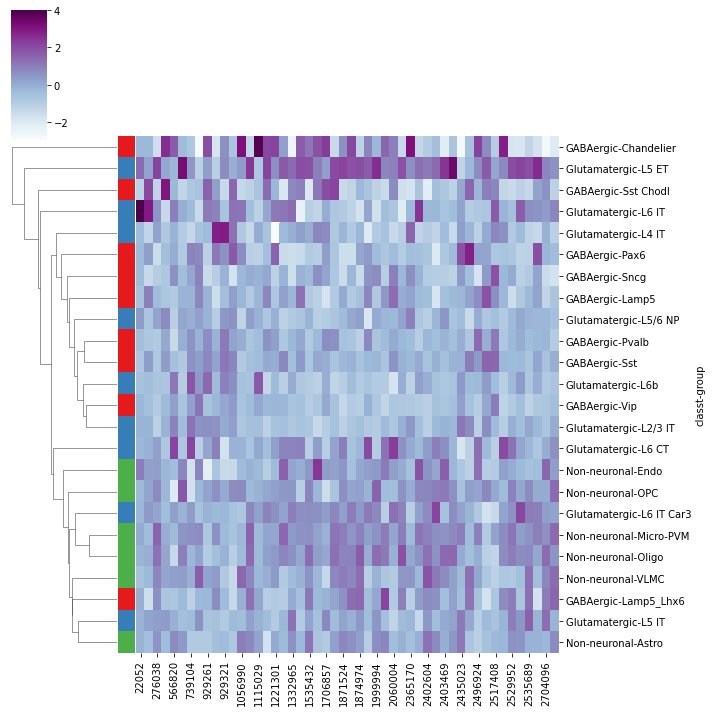

In [53]:
sns.clustermap(df_gene_tp_all_info_mean.dropna(axis=1).loc[:, all_bins_pre], cmap="BuPu", col_cluster=False, row_cluster=True, robust=False, z_score=1, row_colors=[row_colors])


In [52]:
import random

all_bins_p=all_bins_std[all_bins_std>=0.05].index.tolist()
all_bins_pre = df_gene_tp_all_info_mean.dropna(axis=1).columns.intersection(all_bins_p)
all_bins_pre = all_bins_pre.intersection(all_bins)
#bin_random = random.sample(list(all_bins_pre), 50000)

lut = dict(zip( df_gene_tp_all_info_mean.index.get_level_values('classt').drop_duplicates(), sns.color_palette("Set1", df_gene_tp_all_info_mean.index.get_level_values('classt').shape[0]).as_hex()[:]))


row_colors =df_gene_tp_all_info_mean.index.get_level_values('classt').map(lut)

features = df_gene_tp_all_info_mean.dropna(axis=1).loc[:, all_bins_pre]
#features = np.vstack(mean_list).T


umap_2d = UMAP(n_components=2, init='random', random_state=1)


proj_2d = umap_2d.fit_transform(features)
fig_2d = px.scatter(
    proj_2d, x=0, y=1,
    color=df_gene_tp_all_info_mean.index.get_level_values('classt'), labels={'color': 'classt'}
)


fig_2d.show()


In [22]:
all_bins_std.max()

0.08337967097759247

In [19]:
all_bins_p

[]

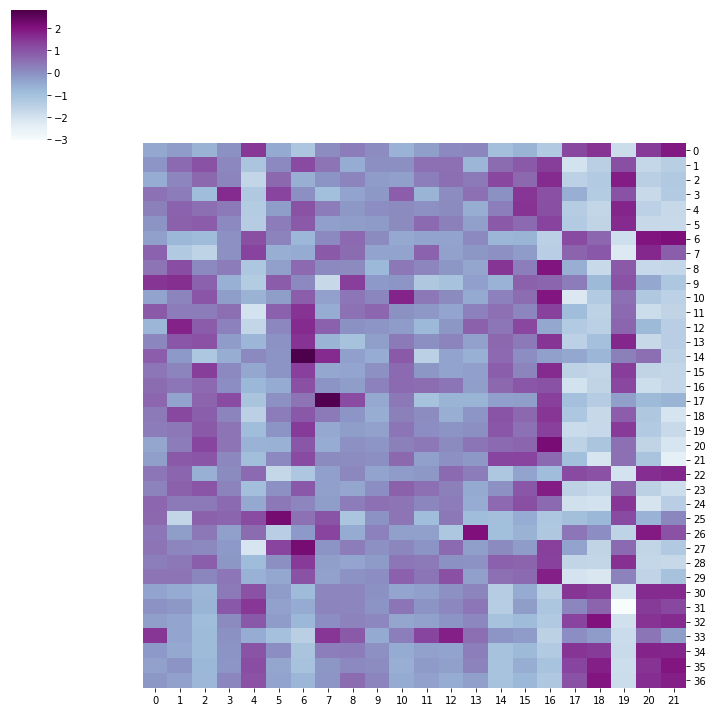

In [424]:
df_hba_modules = pd.read_csv(f'/grid/gillis/data/lohia/hi_c_data_processing/data_human/{SRP_name}/{resolution}/cre_modules.bed', sep='\t', names=['c','d', 'e', 'f', 'ccre', 'chr', 'start', 'end', 'bin_id'])


df_hba_modules = df_hba_modules.drop_duplicates(['bin_id'], keep=False)

mean_list = []
for i in list(range(1,38)):
    m="M"+str(i)
    given_bins = df_hba_modules[df_hba_modules['ccre']==m]['bin_id'].tolist()
    
    mean_list.append(df_gene_tp_all_info_mean.loc[rorg_list , given_bins].mean(axis=1).values.tolist())
    
sns.clustermap(np.vstack(mean_list), cmap="BuPu", col_cluster=False, row_cluster=False, robust=False, z_score=0)


In [ ]:
lut = dict(zip( df_gene_tp_all_info_mean.index.get_level_values('classt').drop_duplicates(), sns.color_palette("Set1", df_gene_tp_all_info_mean.index.get_level_values('classt').shape[0]).as_hex()[:]))


row_colors =df_gene_tp_all_info_mean.index.get_level_values('classt').map(lut)

lut = dict(zip( df_gene_tp_all_info_mean.index.get_level_values('group').drop_duplicates(), sns.color_palette("Paired", df_gene_tp_all_info_mean.index.get_level_values('group').shape[0]).as_hex()[:]))
row_colors2 =df_gene_tp_all_info_mean.index.get_level_values('group').map(lut)
#sns.clustermap(df_gene_tp_all_info_mean.loc[:, all_bins_std[(all_bins_std >= 0.06) & (all_bins_mean >= 0.0)].index.tolist()].reset_index(drop=True), cmap="BuPu", col_cluster=True, robust=False, row_colors=[row_colors])
sns.clustermap(df_gene_tp_all_info_mean.loc[:, all_bins].reset_index(drop=True), cmap="BuPu", col_cluster=True, robust=False, row_colors=[row_colors])
#sns.clustermap(df_gene_tp_all_info_mean.loc[:, bins_bed_cre[bins_bed_cre['cre'] >= 14]['bin_id'].tolist()].reset_index(drop=True), cmap="BuPu", col_cluster=True, robust=False, row_colors=[row_colors])
#sns.clustermap(df_gene_tp_all_info_mean.loc[:, bin_random].reset_index(drop=True), cmap="BuPu", col_cluster=True, robust=False, row_colors=[row_colors])


In [420]:
rorg_list

['l2/3 it',
 'l4 it',
 'l5 it',
 'l6 it',
 'l6 it car3',
 'l6 ct',
 'l6b',
 'l5/6 np',
 'l5 et',
 'sst chodl',
 'sst',
 'pvalb',
 'chandelier',
 'vip',
 'sncg',
 'lamp5',
 'lamp5_lhx6',
 'astro',
 'micro-pvm',
 'opc',
 'oligo',
 'endo']

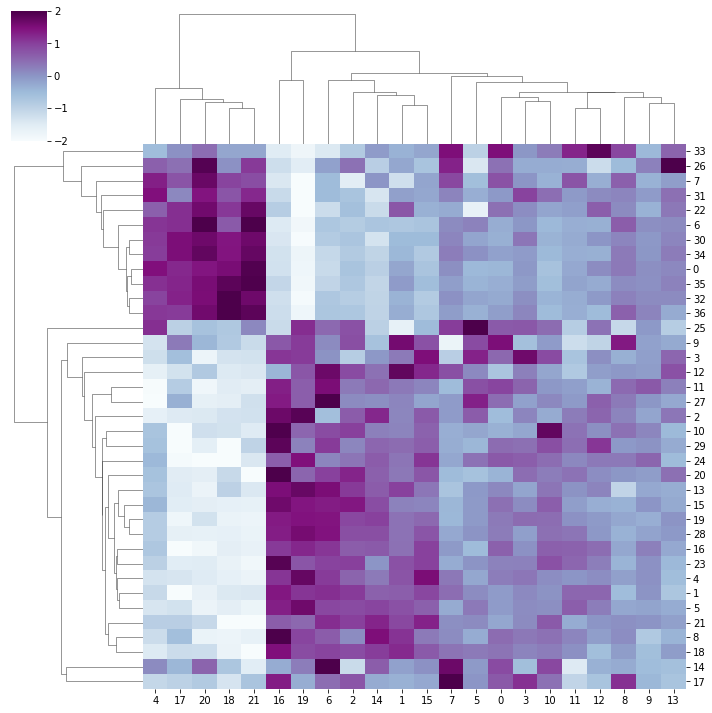

In [426]:
sns.clustermap(np.vstack(mean_list), cmap="BuPu", col_cluster=True, row_cluster=True, robust=False, z_score=0, vmax=2, vmin=-2)



In [413]:
df_gene_tp_all_info_mean.loc[rorg_list , given_bins]

1201      1679      2148      2149      2315      2839     \
l2/3 it     0.009662  0.014493  0.000000  0.000000  0.009662  0.000000   
l4 it       0.016260  0.012195  0.000000  0.004065  0.004065  0.000000   
l5 it       0.020202  0.010101  0.000000  0.005051  0.005051  0.005051   
l6 it       0.009050  0.013575  0.004525  0.000000  0.004525  0.004525   
l6 it car3  0.004000  0.032000  0.000000  0.016000  0.000000  0.008000   
l6 ct       0.007353  0.007353  0.000000  0.000000  0.000000  0.000000   
l6b         0.000000  0.000000  0.000000  0.000000  0.008475  0.008475   
l5/6 np     0.000000  0.006369  0.000000  0.012739  0.000000  0.000000   
l5 et       0.012821  0.017094  0.004274  0.012821  0.004274  0.004274   
sst chodl   0.018587  0.022305  0.003717  0.000000  0.007435  0.000000   
sst         0.000000  0.019139  0.004785  0.009569  0.014354  0.009569   
pvalb       0.000000  0.003817  0.000000  0.030534  0.007634  0.007634   
chandelier  0.018182  0.004545  0.009091  0.009091  0.000000  0.000000   
vip         0.015152  0.010101  0.000000  0.025253  0.010101  0.000000   
sncg        0.005814  0.017442  0.000000  0.017442  0.000000  0.005814   
lamp5       0.004785  0.014354  0.000000  0.004785  0.004785  0.000000   
lamp5_lhx6  0.000000  0.011765  0.005882  0.000000  0.000000  0.005882   
astro       0.015504  0.025840  0.005168  0.015504  0.015504  0.000000   
micro-pvm   0.016166  0.023095  0.002309  0.006928  0.004619  0.009238   
opc         0.014151  0.018868  0.000000  0.009434  0.004717  0.004717   
oligo       0.020151  0.025189  0.010076  0.012594  0.002519  0.007557   
endo        0.012594  0.015113  0.000000  0.010076  0.010076  0.005038   

             2840      3890      5329      5388     ...   1668978   1668979  \
l2/3 it     0.004831  0.028986  0.004831  0.004831  ...  0.014019  0.009346   
l4 it       0.000000  0.008130  0.000000  0.004065  ...  0.015326  0.015326   
l5 it       0.015152  0.010101  0.005051  0.005051  ...  0.014286  0.009524   
l6 it       0.009050  0.022624  0.022624  0.004525  ...  0.017021  0.000000   
l6 it car3  0.008000  0.012000  0.016000  0.004000  ...  0.018587  0.003717   
l6 ct       0.000000  0.007353  0.000000  0.007353  ...  0.006897  0.013793   
l6b         0.000000  0.000000  0.000000  0.008475  ...  0.017391  0.000000   
l5/6 np     0.006369  0.038217  0.000000  0.000000  ...  0.017143  0.000000   
l5 et       0.012821  0.008547  0.008547  0.008547  ...  0.003984  0.007968   
sst chodl   0.003717  0.011152  0.007435  0.007435  ...  0.013793  0.003448   
sst         0.019139  0.023923  0.004785  0.009569  ...  0.013575  0.004525   
pvalb       0.000000  0.022901  0.003817  0.011450  ...  0.003663  0.000000   
chandelier  0.000000  0.022727  0.000000  0.004545  ...  0.000000  0.008368   
vip         0.010101  0.005051  0.005051  0.010101  ...  0.000000  0.009524   
sncg        0.005814  0.023256  0.011628  0.005814  ...  0.010811  0.005405   
lamp5       0.009569  0.019139  0.009569  0.000000  ...  0.013761  0.004587   
lamp5_lhx6  0.000000  0.011765  0.000000  0.005882  ...  0.000000  0.000000   
astro       0.000000  0.012920  0.007752  0.010336  ...  0.016949  0.009685   
micro-pvm   0.006928  0.013857  0.002309  0.011547  ...  0.008421  0.010526   
opc         0.004717  0.014151  0.000000  0.000000  ...  0.000000  0.004444   
oligo       0.007557  0.020151  0.005038  0.005038  ...  0.011765  0.014118   
endo        0.002519  0.022670  0.005038  0.005038  ...  0.004751  0.007126   

             1670169   1670874   1670883   1670884   1673064   1673373  \
l2/3 it     0.014019  0.000000  0.004673  0.000000  0.000000  0.032710   
l4 it       0.011494  0.003831  0.011494  0.003831  0.000000  0.011494   
l5 it       0.009524  0.009524  0.009524  0.000000  0.004762  0.009524   
l6 it       0.004255  0.008511  0.004255  0.000000  0.000000  0.012766   
l6 it car3  0.018587  0.003717  0.011152  0.000000  0.000000  0.026022   
l6 ct       0.006897  0.006897  0.013793  0.0000

In [368]:
df_gene_tp_all_info_mean[0].reset_index()

classt       group   cell_type    0
0       GABAergic  Chandelier  Chandelier  0.0
1       GABAergic       Lamp5       Lamp5  0.0
2       GABAergic  Lamp5_Lhx6  Lamp5_Lhx6  0.0
3       GABAergic        Pax6        Pax6  0.0
4       GABAergic       Pvalb       Pvalb  0.0
5       GABAergic        Sncg        Sncg  0.0
6       GABAergic         Sst         Sst  0.0
7       GABAergic   Sst Chodl   Sst Chodl  0.0
8       GABAergic         Vip         Vip  0.0
9   Glutamatergic     L2/3 IT     L2/3 IT  0.0
10  Glutamatergic       L4 IT       L4 IT  0.0
11  Glutamatergic       L5 ET       L5 ET  0.0
12  Glutamatergic       L5 IT       L5 IT  0.0
13  Glutamatergic     L5/6 NP     L5/6 NP  0.0
14  Glutamatergic       L6 CT       L6 CT  0.0
15  Glutamatergic       L6 IT       L6 IT  0.0
16  Glutamatergic  L6 IT Car3  L6 IT Car3  0.0
17  Glutamatergic         L6b         L6b  0.0
18   Non-neuronal       Astro       Astro  0.0
19   Non-neuronal        Endo        Endo  0.0
20   Non-neuronal   Micro-PVM   Micro-PVM  0.0
21   Non-neuronal         OPC         OPC  0.0
22   Non-neuronal       Oligo       Oligo  0.0
23   Non-neuronal        VLMC        VLMC  0.0

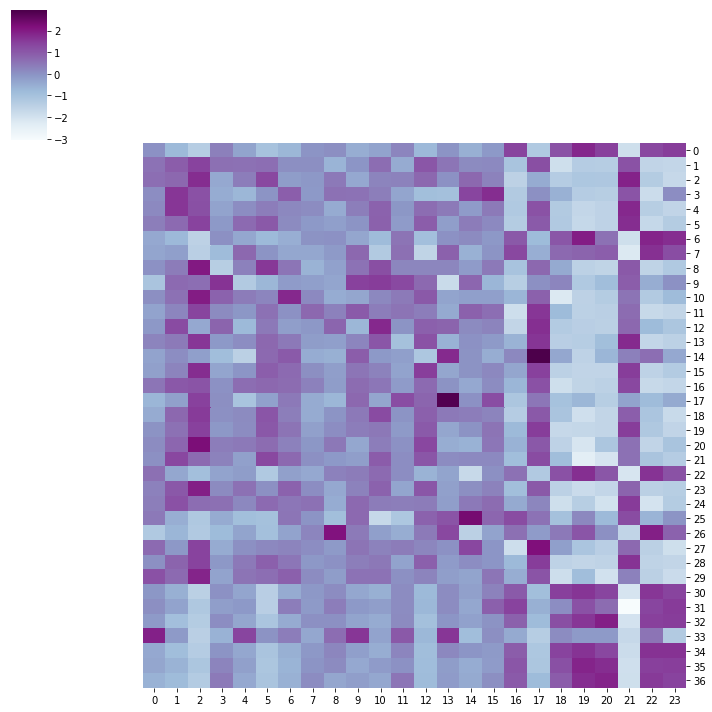

In [337]:
sns.clustermap(np.vstack(mean_list), cmap="BuPu", col_cluster=False, row_cluster=False, robust=False, z_score=0)




In [348]:
my_mean_index = df_gene_tp_all_info_mean.index.get_level_values('group').tolist()

In [371]:
df_gene_tp_all_info_mean.index = df_gene_tp_all_info_mean.index.get_level_values('group')

In [407]:
df_gene_tp_all_info_mean.index = mm

In [409]:
df_gene_tp_all_info_mean

0        1        2         3        4         5        6        \
chandelier      0.0      0.0  0.00000  0.000000      0.0  0.000000      0.0   
lamp5           0.0      0.0  0.00000  0.000000      0.0  0.000000      0.0   
lamp5_lhx6      0.0      0.0  0.00000  0.000000      0.0  0.000000      0.0   
pax6            0.0      0.0  0.00000  0.004115      0.0  0.000000      0.0   
pvalb           0.0      0.0  0.00000  0.000000      0.0  0.000000      0.0   
sncg            0.0      0.0  0.00000  0.000000      0.0  0.000000      0.0   
sst             0.0      0.0  0.00000  0.000000      0.0  0.000000      0.0   
sst chodl       0.0      0.0  0.00000  0.000000      0.0  0.000000      0.0   
vip             0.0      0.0  0.00000  0.000000      0.0  0.000000      0.0   
l2/3 it         0.0      0.0  0.00000  0.000000      0.0  0.000000      0.0   
l4 it           0.0      0.0  0.00000  0.000000      0.0  0.000000      0.0   
l5 et           0.0      0.0  0.00000  0.000000      0.0  0.000000      0.0   
l5 it           0.0      0.0  0.00000  0.000000      0.0  0.000000      0.0   
l5/6 np         0.0      0.0  0.00000  0.000000      0.0  0.000000      0.0   
l6 ct           0.0      0.0  0.00000  0.000000      0.0  0.000000      0.0   
l6 it           0.0      0.0  0.00000  0.000000      0.0  0.000000      0.0   
l6 it car3      0.0      0.0  0.00000  0.000000      0.0  0.000000      0.0   
l6b             0.0      0.0  0.00000  0.000000      0.0  0.000000      0.0   
astro           0.0      0.0  0.00000  0.000000      0.0  0.000000      0.0   
endo            0.0      0.0  0.00000  0.000000      0.0  0.000000      0.0   
micro-pvm       0.0      0.0  0.00000  0.000000      0.0  0.002309      0.0   
opc             0.0      0.0  0.00000  0.000000      0.0  0.000000      0.0   
oligo           0.0      0.0  0.00000  0.000000      0.0  0.000000      0.0   
vlmc            0.0      0.0  0.00266  0.000000      0.0  0.000000      0.0   

            7        8        9        ...  2875002  2875003  2875004  \
chandelier      0.0      0.0      0.0  ...      0.0      0.0      0.0   
lamp5           0.0      0.0      0.0  ...      0.0      0.0      0.0   
lamp5_lhx6      0.0      0.0      0.0  ...      0.0      0.0      0.0   
pax6            0.0      0.0      0.0  ...      0.0      0.0      0.0   
pvalb           0.0      0.0      0.0  ...      0.0      0.0      0.0   
sncg            0.0      0.0      0.0  ...      0.0      0.0      0.0   
sst             0.0      0.0      0.0  ...      0.0      0.0      0.0   
sst chodl       0.0      0.0      0.0  ...      0.0      0.0      0.0   
vip             0.0      0.0      0.0  ...      0.0      0.0      0.0   
l2/3 it         0.0      0.0      0.0  ...      0.0      0.0      0.0   
l4 it           0.0      0.0      0.0  ...      0.0      0.0      0.0   
l5 et           0.0      0.0      0.0  ...      0.0      0.0      0.0   
l5 it           0.0      0.0      0.0  ...      0.0      0.0      0.0   
l5/6 np         0.0      0.0      0.0  ...      0.0      0.0      0.0   
l6 ct           0.0      0.0      0.0  ...      0.0      0.0      0.0   
l6 it           0.0      0.0      0.0  ...      0.0      0.0      0.0   
l6 it car3      0.0      0.0      0.0  ...      0.0      0.0      0.0   
l6b             0.0      0.0      0.0  ...      0.0      0.0      0.0   
astro           0.0      0.0      0.0  ...      0.0      0.0      0.0   
endo            0.0      0.0      0.0  ...      0.0      0.0      0.0   
micro-pvm       0.0      0.0      0.0  ...      0.0      0.0      0.0   
opc             0.0      0.0      0.0  ...      0.0      0.0      0.0   
oligo           0.0      0.0      0.0  ...      0.0      0.0      0.0   
vlmc            0.0      0.0      0.0  ...      0.0      0.0      0.0   

            2875005  2875006  2875007  2875008  2875009  2875010  2875011  
chandelier      0.0      0.0      0.0      0.0      0.0      0.0      0.0  
lamp5           0.0      0.0      0.0      0.0      0.0   

In [410]:
df_gene_tp_all_info_mean.loc[rorg_list , :]

0        1        2        3        4         5        6        \
l2/3 it         0.0      0.0      0.0      0.0      0.0  0.000000      0.0   
l4 it           0.0      0.0      0.0      0.0      0.0  0.000000      0.0   
l5 it           0.0      0.0      0.0      0.0      0.0  0.000000      0.0   
l6 it           0.0      0.0      0.0      0.0      0.0  0.000000      0.0   
l6 it car3      0.0      0.0      0.0      0.0      0.0  0.000000      0.0   
l6 ct           0.0      0.0      0.0      0.0      0.0  0.000000      0.0   
l6b             0.0      0.0      0.0      0.0      0.0  0.000000      0.0   
l5/6 np         0.0      0.0      0.0      0.0      0.0  0.000000      0.0   
l5 et           0.0      0.0      0.0      0.0      0.0  0.000000      0.0   
sst chodl       0.0      0.0      0.0      0.0      0.0  0.000000      0.0   
sst             0.0      0.0      0.0      0.0      0.0  0.000000      0.0   
pvalb           0.0      0.0      0.0      0.0      0.0  0.000000      0.0   
chandelier      0.0      0.0      0.0      0.0      0.0  0.000000      0.0   
vip             0.0      0.0      0.0      0.0      0.0  0.000000      0.0   
sncg            0.0      0.0      0.0      0.0      0.0  0.000000      0.0   
lamp5           0.0      0.0      0.0      0.0      0.0  0.000000      0.0   
lamp5_lhx6      0.0      0.0      0.0      0.0      0.0  0.000000      0.0   
astro           0.0      0.0      0.0      0.0      0.0  0.000000      0.0   
micro-pvm       0.0      0.0      0.0      0.0      0.0  0.002309      0.0   
opc             0.0      0.0      0.0      0.0      0.0  0.000000      0.0   
oligo           0.0      0.0      0.0      0.0      0.0  0.000000      0.0   
endo            0.0      0.0      0.0      0.0      0.0  0.000000      0.0   

            7        8        9        ...  2875002  2875003  2875004  \
l2/3 it         0.0      0.0      0.0  ...      0.0      0.0      0.0   
l4 it           0.0      0.0      0.0  ...      0.0      0.0      0.0   
l5 it           0.0      0.0      0.0  ...      0.0      0.0      0.0   
l6 it           0.0      0.0      0.0  ...      0.0      0.0      0.0   
l6 it car3      0.0      0.0      0.0  ...      0.0      0.0      0.0   
l6 ct           0.0      0.0      0.0  ...      0.0      0.0      0.0   
l6b             0.0      0.0      0.0  ...      0.0      0.0      0.0   
l5/6 np         0.0      0.0      0.0  ...      0.0      0.0      0.0   
l5 et           0.0      0.0      0.0  ...      0.0      0.0      0.0   
sst chodl       0.0      0.0      0.0  ...      0.0      0.0      0.0   
sst             0.0      0.0      0.0  ...      0.0      0.0      0.0   
pvalb           0.0      0.0      0.0  ...      0.0      0.0      0.0   
chandelier      0.0      0.0      0.0  ...      0.0      0.0      0.0   
vip             0.0      0.0      0.0  ...      0.0      0.0      0.0   
sncg            0.0      0.0      0.0  ...      0.0      0.0      0.0   
lamp5           0.0      0.0      0.0  ...      0.0      0.0      0.0   
lamp5_lhx6      0.0      0.0      0.0  ...      0.0      0.0      0.0   
astro           0.0      0.0      0.0  ...      0.0      0.0      0.0   
micro-pvm       0.0      0.0      0.0  ...      0.0      0.0      0.0   
opc             0.0      0.0      0.0  ...      0.0      0.0      0.0   
oligo           0.0      0.0      0.0  ...      0.0      0.0      0.0   
endo            0.0      0.0      0.0  ...      0.0      0.0      0.0   

            2875005  2875006  2875007  2875008  2875009  2875010  2875011  
l2/3 it         0.0      0.0      0.0      0.0      0.0      0.0      0.0  
l4 it           0.0      0.0      0.0      0.0      0.0      0.0      0.0  
l5 it           0.0      0.0      0.0      0.0      0.0      0.0      0.0  
l6 it           0.0      0.0      0.0      0.0      0.0      0.0      0.0  
l6 it car3      0.0      0.0      0.0      0.0      0.0      0.0      0.0  
l6 ct           0.0      0.0      0.0      0.0      0.0      0.0      0.0  
l6b  

In [404]:
rorg_list = [x for x in ll if x in mm]

In [402]:
mm = [x.lower() for x in df_gene_tp_all_info_mean.index.tolist()]

In [397]:
ll

['l2/3 it',
 'l4 it',
 'l5 it',
 'l6 it',
 'l6 it car3',
 'l6 ct',
 'l6b',
 'l5/6 np',
 'l5 et',
 'sst chodl',
 'sst',
 'pvalb',
 'chandelier',
 'vip',
 'sncg',
 'lamp5',
 'lamp5_lhx6',
 'astro',
 'micro-pvm',
 'opc',
 'oligo',
 'endo']

In [389]:
df_gene_tp_all_info_mean.loc[ll, :]

KeyError: "Passing list-likes to .loc or [] with any missing labels is no longer supported. The following labels were missing: Index(['L6 IT CAR3', 'L6B', 'SST CHODL', 'SST', 'PVALB',\n       ...\n       'LAMP5_LHX6', 'ASTRO', 'MICRO-PVM', 'OLIGO', 'ENDO'],\n      dtype='object', name='group', length=14). See https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike"

In [349]:
my_mean_index_mapped = [x]

['Chandelier',
 'Lamp5',
 'Lamp5_Lhx6',
 'Pax6',
 'Pvalb',
 'Sncg',
 'Sst',
 'Sst Chodl',
 'Vip',
 'L2/3 IT',
 'L4 IT',
 'L5 ET',
 'L5 IT',
 'L5/6 NP',
 'L6 CT',
 'L6 IT',
 'L6 IT Car3',
 'L6b',
 'Astro',
 'Endo',
 'Micro-PVM',
 'OPC',
 'Oligo',
 'VLMC']

In [350]:
module_part_name = ["AMY", "PRERC", "ITL23", "ITL34", "ITL4", "ITL45", "ITL5", "ITL6_1", "ITL6_2", "ITV1C", "CT", "L6B", "NP", "ET", "SUB", "CBGRC", "SST_CHODL", "SST", "PVALB", "PV_ChCs", "VIP", "SNCG", "LAMP5", "LAMP5_LHX6", "FOXP2", "BNGA", "SIGA", "BFEXA", "MSN", "CBGA", "CNGA", "CHO", "MBGA", "THMGA", "ASCT", "ASCNT", "ACBGM", "MGC", "OPC", "OGC", "EC", "SMC"]




In [394]:
ll = [cell_type_map[x].lower() for x in module_part_name if x in cell_type_map.keys()]

In [338]:
cell_type_map = {'ITL23' : 'L2/3 IT' ,
'ITL4' : 'L4 IT' ,
'ITL5' : 'L5 IT' ,
'ITL6_1' : 'L6 IT' ,
'ITL6_2' : 'L6 IT CAR3' ,
'CT' : 'L6 CT' ,
'L6B' : 'L6B' ,
'NP' : 'L5/6 NP' ,
'ET' : 'L5 ET' ,
'SST_CHODL' : 'SST CHODL' ,
'SST' : 'SST' ,
'PVALB' : 'PVALB' ,
'PV_ChCs' : 'CHANDELIER' ,
'VIP' : 'VIP' ,
'SNCG' : 'SNCG' ,
'LAMP5' : 'LAMP5' ,
'LAMP5_LHX6' : 'LAMP5_LHX6' ,
'ASCT' : 'ASTRO' ,
'MGC' : 'MICRO-PVM' ,
'OPC' : 'OPC' ,
'OGC' : 'OLIGO' ,
'EC' : 'ENDO' ,
'Glutamatergic' : 'Glutamatergic',
'GABAergic' : 'GABAergic',
'Non-neuronal' : 'Non-neuronal'          
}

In [341]:
df_gene_tp_all_info_mean.index[0]

('GABAergic', 'Chandelier', 'Chandelier')

In [318]:
given_bins = df_hba_modules[df_hba_modules['ccre']=='M1']['bin_id'].tolist()

In [322]:
mean_list.append(df_gene_tp_all_info_mean.loc[:, given_bins].mean(axis=1).values.tolist())

array([0.0190263 , 0.01754243, 0.01645683, 0.01959836, 0.01837917,
       0.01711397, 0.01765468, 0.01897111, 0.01911855, 0.01802994,
       0.01843141, 0.01943546, 0.01759664, 0.01897129, 0.01795532,
       0.01878263, 0.02157959, 0.01672517, 0.02113047, 0.02242674,
       0.02173176, 0.01545083, 0.02148279, 0.02179741], dtype=float32)

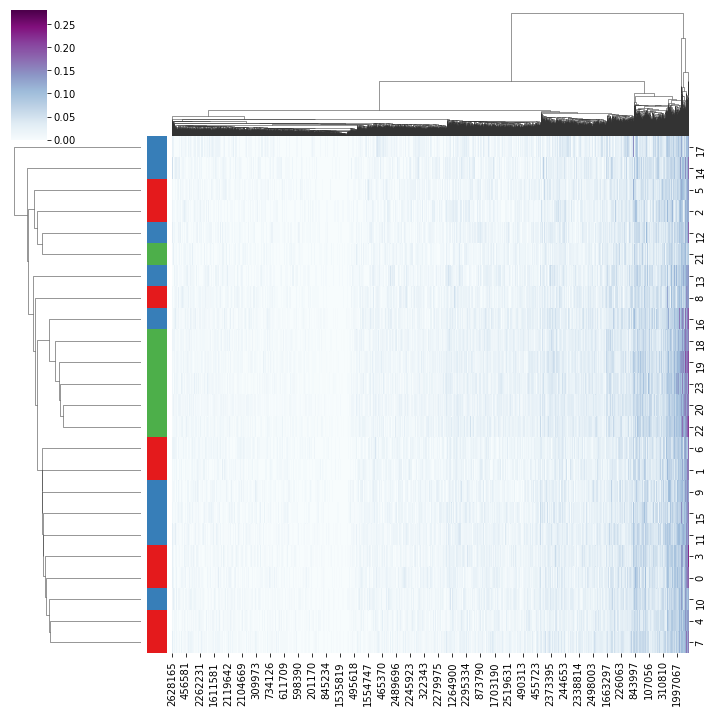

In [320]:
lut = dict(zip( df_gene_tp_all_info_mean.index.get_level_values('classt').drop_duplicates(), sns.color_palette("Set1", df_gene_tp_all_info_mean.index.get_level_values('classt').shape[0]).as_hex()[:]))


row_colors =df_gene_tp_all_info_mean.index.get_level_values('classt').map(lut)

lut = dict(zip( df_gene_tp_all_info_mean.index.get_level_values('group').drop_duplicates(), sns.color_palette("Paired", df_gene_tp_all_info_mean.index.get_level_values('group').shape[0]).as_hex()[:]))
row_colors2 =df_gene_tp_all_info_mean.index.get_level_values('group').map(lut)
#sns.clustermap(df_gene_tp_all_info_mean.loc[:, all_bins_std[(all_bins_std >= 0.06) & (all_bins_mean >= 0.0)].index.tolist()].reset_index(drop=True), cmap="BuPu", col_cluster=True, robust=False, row_colors=[row_colors])
sns.clustermap(df_gene_tp_all_info_mean.loc[:, given_bins].reset_index(drop=True), cmap="BuPu", col_cluster=True, robust=False, row_colors=[row_colors])
#sns.clustermap(df_gene_tp_all_info_mean.loc[:, bins_bed_cre[bins_bed_cre['cre'] >= 14]['bin_id'].tolist()].reset_index(drop=True), cmap="BuPu", col_cluster=True, robust=False, row_colors=[row_colors])
#sns.clustermap(df_gene_tp_all_info_mean.loc[:, bin_random].reset_index(drop=True), cmap="BuPu", col_cluster=True, robust=False, row_colors=[row_colors])


In [116]:
all_bins_std.max()

0.06861679255962372

In [31]:
all_bins_mean.max()

0.9992454648017883

In [236]:


    input_path=f'/grid/gillis/data/lohia/hi_c_data_processing/data_{species}/{SRP_name}/{resolution}/max/'
    bins_bede = pd.read_csv(f'{input_path}/all_bins.bed', names=['chr', 'start', 'end', 'bin_id'])
    bins_bede['bin_id'] = bins_bede.index
    #bins_bed['pos'] = bins_bed['chr'] + '_' + bins_bed['start'].astype('str')
    
    bins_bede.to_csv(f'{input_path}/all_bins_true.bed', index=False, header=False, sep='\t')

    os.system(f"~/.conda/envs/hicexplorer/bin/bedtools intersect -c -b /grid/gillis/data/lohia/hi_c_data_processing/data_human/aggregates/li2022/screen_v2/GRCh38-ccREs.bed -a /grid/gillis/data/lohia/hi_c_data_processing/data_{species}/{SRP_name}/{resolution}/max/all_bins_true.bed >  /grid/gillis/data/lohia/hi_c_data_processing/data_human/{SRP_name}/{resolution}/cre_intersect.bed")
    
    bins_bed_cre = pd.read_csv(f'/grid/gillis/data/lohia/hi_c_data_processing/data_human/{SRP_name}/{resolution}/cre_intersect.bed', names=['chr', 'start', 'end', 'bin_id', 'cre'], sep='\t')

In [253]:
gi = list(set.intersection(set(bins_bed_cre[bins_bed_cre['cre'] >= 1]['bin_id'].tolist()), (set( all_bins_std[all_bins_std >= 0.05].index.tolist()))) )


In [254]:
len(gi)

3

In [256]:
bins_bed_cre[bins_bed_cre['bin_id'].isin(gi)]

chr     start       end   bin_id  cre
1874974  chr11  66289000  66290000  1874974    3
2402604  chr16   2155000   2156000  2402604    2
2861851  chr22  37658000  37659000  2861851    3

In [269]:
marker_list[marker_list['Ensembl_gene_identifier'].isin(['ENSG00000233360'])]

Empty DataFrame
Columns: [classt, group, cell_type, Ensembl_gene_identifier]
Index: []

In [271]:
marker_list

classt  group cell_type Ensembl_gene_identifier
16527  Glutamatergic  L4 IT     L4 IT         ENSG00000053900
15055  Glutamatergic  L6 CT     L6 CT         ENSG00000197594
14479  Glutamatergic  L6 CT     L6 CT         ENSG00000011347
5512       GABAergic   Pax6      Pax6         ENSG00000133818
8960       GABAergic   Pax6      Pax6         ENSG00000004846
...              ...    ...       ...                     ...
16593  Glutamatergic  L4 IT     L4 IT         ENSG00000147676
16482  Glutamatergic  L4 IT     L4 IT         ENSG00000158683
10344      GABAergic   Sncg      Sncg         ENSG00000180998
17380  Glutamatergic  L6 IT     L6 IT         ENSG00000116266
18906   Non-neuronal   VLMC      VLMC         ENSG00000123243

[6586 rows x 4 columns]

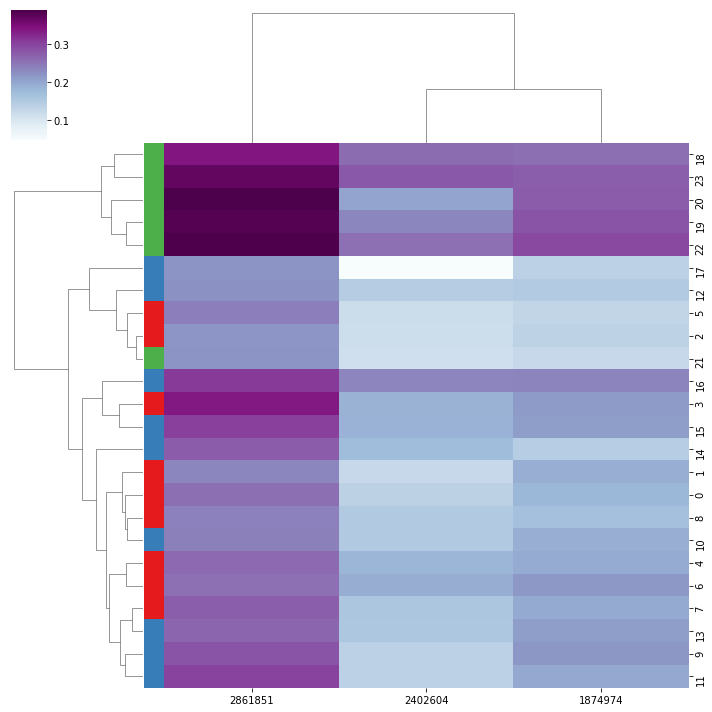

In [255]:
lut = dict(zip( df_gene_tp_all_info_mean.index.get_level_values('classt').drop_duplicates(), sns.color_palette("Set1", df_gene_tp_all_info_mean.index.get_level_values('classt').shape[0]).as_hex()[:]))


row_colors =df_gene_tp_all_info_mean.index.get_level_values('classt').map(lut)

lut = dict(zip( df_gene_tp_all_info_mean.index.get_level_values('group').drop_duplicates(), sns.color_palette("Paired", df_gene_tp_all_info_mean.index.get_level_values('group').shape[0]).as_hex()[:]))
row_colors2 =df_gene_tp_all_info_mean.index.get_level_values('group').map(lut)
#sns.clustermap(df_gene_tp_all_info_mean.loc[:, all_bins_std[(all_bins_std >= 0.06) & (all_bins_mean >= 0.0)].index.tolist()].reset_index(drop=True), cmap="BuPu", col_cluster=True, robust=False, row_colors=[row_colors])
sns.clustermap(df_gene_tp_all_info_mean.loc[:, gi].reset_index(drop=True), cmap="BuPu", col_cluster=True, robust=False, row_colors=[row_colors])
#sns.clustermap(df_gene_tp_all_info_mean.loc[:, bins_bed_cre[bins_bed_cre['cre'] >= 14]['bin_id'].tolist()].reset_index(drop=True), cmap="BuPu", col_cluster=True, robust=False, row_colors=[row_colors])
#sns.clustermap(df_gene_tp_all_info_mean.loc[:, bin_random].reset_index(drop=True), cmap="BuPu", col_cluster=True, robust=False, row_colors=[row_colors])


In [94]:
%matplotlib inline
import seaborn as sns
import random
bin_random = random.sample(range(2875012 ), 1000)

In [17]:
%matplotlib inline
import seaborn as sns

In [273]:
df_gene_tp_all_info_mean

0        1        2         3        \
classt        group      cell_type                                         
GABAergic     Chandelier Chandelier      0.0      0.0  0.00000  0.000000   
              Lamp5      Lamp5           0.0      0.0  0.00000  0.000000   
              Lamp5_Lhx6 Lamp5_Lhx6      0.0      0.0  0.00000  0.000000   
              Pax6       Pax6            0.0      0.0  0.00000  0.004115   
              Pvalb      Pvalb           0.0      0.0  0.00000  0.000000   
              Sncg       Sncg            0.0      0.0  0.00000  0.000000   
              Sst        Sst             0.0      0.0  0.00000  0.000000   
              Sst Chodl  Sst Chodl       0.0      0.0  0.00000  0.000000   
              Vip        Vip             0.0      0.0  0.00000  0.000000   
Glutamatergic L2/3 IT    L2/3 IT         0.0      0.0  0.00000  0.000000   
              L4 IT      L4 IT           0.0      0.0  0.00000  0.000000   
              L5 ET      L5 ET           0.0      0.0  0.00000  0.000000   
              L5 IT      L5 IT           0.0      0.0  0.00000  0.000000   
              L5/6 NP    L5/6 NP         0.0      0.0  0.00000  0.000000   
              L6 CT      L6 CT           0.0      0.0  0.00000  0.000000   
              L6 IT      L6 IT           0.0      0.0  0.00000  0.000000   
              L6 IT Car3 L6 IT Car3      0.0      0.0  0.00000  0.000000   
              L6b        L6b             0.0      0.0  0.00000  0.000000   
Non-neuronal  Astro      Astro           0.0      0.0  0.00000  0.000000   
              Endo       Endo            0.0      0.0  0.00000  0.000000   
              Micro-PVM  Micro-PVM       0.0      0.0  0.00000  0.000000   
              OPC        OPC             0.0      0.0  0.00000  0.000000   
              Oligo      Oligo           0.0      0.0  0.00000  0.000000   
              VLMC       VLMC            0.0      0.0  0.00266  0.000000   

                                     4         5        6        7        \
classt        group      cell_type                                         
GABAergic     Chandelier Chandelier      0.0  0.000000      0.0      0.0   
              Lamp5      Lamp5           0.0  0.000000      0.0      0.0   
              Lamp5_Lhx6 Lamp5_Lhx6      0.0  0.000000      0.0      0.0   
              Pax6       Pax6            0.0  0.000000      0.0      0.0   
              Pvalb      Pvalb           0.0  0.000000      0.0      0.0   
              Sncg       Sncg            0.0  0.000000      0.0      0.0   
              Sst        Sst             0.0  0.000000      0.0      0.0   
              Sst Chodl  Sst Chodl       0.0  0.000000      0.0      0.0   
              Vip        Vip             0.0  0.000000      0.0      0.0   
Glutamatergic L2/3 IT    L2/3 IT         0.0  0.000000      0.0      0.0   
              L4 IT      L4 IT           0.0  0.000000      0.0      0.0   
              L5 ET      L5 ET           0.0  0.000000      0.0      0.0   
              L5 IT      L5 IT           0.0  0.000000      0.0      0.0   
              L5/6 NP    L5/6 NP         0.0  0.000000      0.0      0.0   
              L6 CT      L6 CT           0.0  0.000000      0.0      0.0   
              L6 IT      L6 IT           0.0  0.000000      0.0      0.0   
              L6 IT Car3 L6 IT Car3      0.0  0.000000      0.0      0.0   
              L6b        L6b             0.0  0.000000      0.0      0.0   
Non-neuronal  Astro      Astro           0.0  0.000000      0.0      0.0   
              Endo       Endo            0.0  0.000000      0.0      0.0   
              Micro-PVM  Micro-PVM       0.0  0.002309      0.0      0.0   
              OPC        OPC             0.0  0.000000      0.0      0.0   
              Oligo      Oligo           0.0  0.000000      0.0      0.0   
              VLMC       VLMC            0.0  0.000000      0.0      0.0   

                                     8        9        ...  2875002  2875003  \
cla

/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


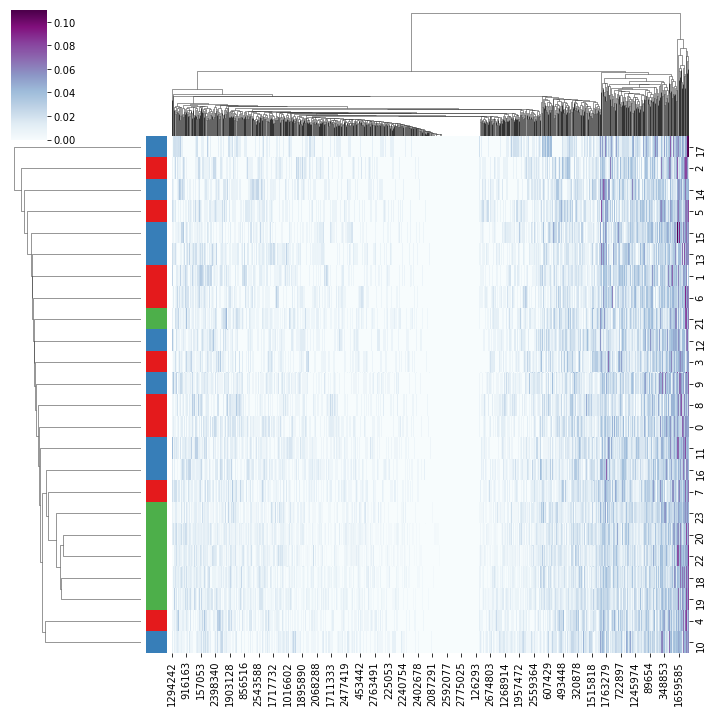

In [95]:
lut = dict(zip( df_gene_tp_all_info_mean.index.get_level_values('classt').drop_duplicates(), sns.color_palette("Set1", df_gene_tp_all_info_mean.index.get_level_values('classt').shape[0]).as_hex()[:]))


row_colors =df_gene_tp_all_info_mean.index.get_level_values('classt').map(lut)

lut = dict(zip( df_gene_tp_all_info_mean.index.get_level_values('group').drop_duplicates(), sns.color_palette("Set1", df_gene_tp_all_info_mean.index.get_level_values('group').shape[0]).as_hex()[:]))
row_colors2 =df_gene_tp_all_info_mean.index.get_level_values('group').map(lut)
sns.clustermap(df_gene_tp_all_info_mean.loc[:, bin_random].reset_index(drop=True), cmap="BuPu", col_cluster=True, robust=False, row_colors=[row_colors])


In [77]:
dj = pd.DataFrame({"A":[12, 4, 5, 44, 12],
                "B":[5, 2, 54, 3, 2],
                "C":[20, 16, 7, 3, 8],
                "D":[14, 3, 17, 2, np.nan]})
  


In [78]:
dj.groupby(['A']).mean()

B     C     D
A                   
4    2.0  16.0   3.0
5   54.0   7.0  17.0
12   3.5  14.0  14.0
44   3.0   3.0   2.0

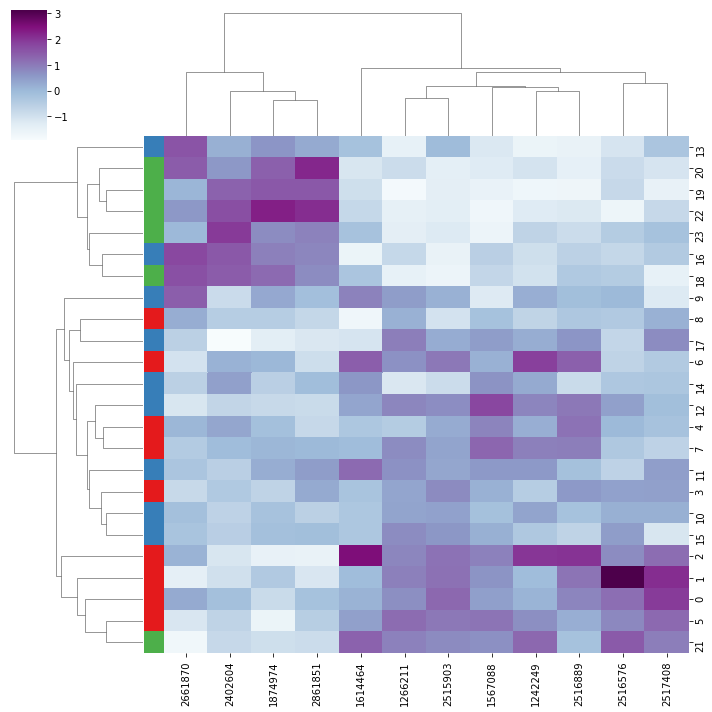

In [160]:
lut = dict(zip( df_gene_tp_all_info_mean.index.get_level_values('classt').drop_duplicates(), sns.color_palette("Set1", df_gene_tp_all_info_mean.index.get_level_values('classt').shape[0]).as_hex()[:]))


row_colors =df_gene_tp_all_info_mean.index.get_level_values('classt').map(lut)

lut = dict(zip( df_gene_tp_all_info_mean.index.get_level_values('group').drop_duplicates(), sns.color_palette("Set1", df_gene_tp_all_info_mean.index.get_level_values('group').shape[0]).as_hex()[:]))
row_colors2 =df_gene_tp_all_info_mean.index.get_level_values('group').map(lut)
sns.clustermap(df_gene_tp_all_info_mean.loc[:, all_bins_std[(all_bins_std >= 0.05) & (all_bins_mean >= 0.1)].index.tolist()].reset_index(drop=True), cmap="BuPu", col_cluster=True, robust=False, row_colors=[row_colors], z_score=1)


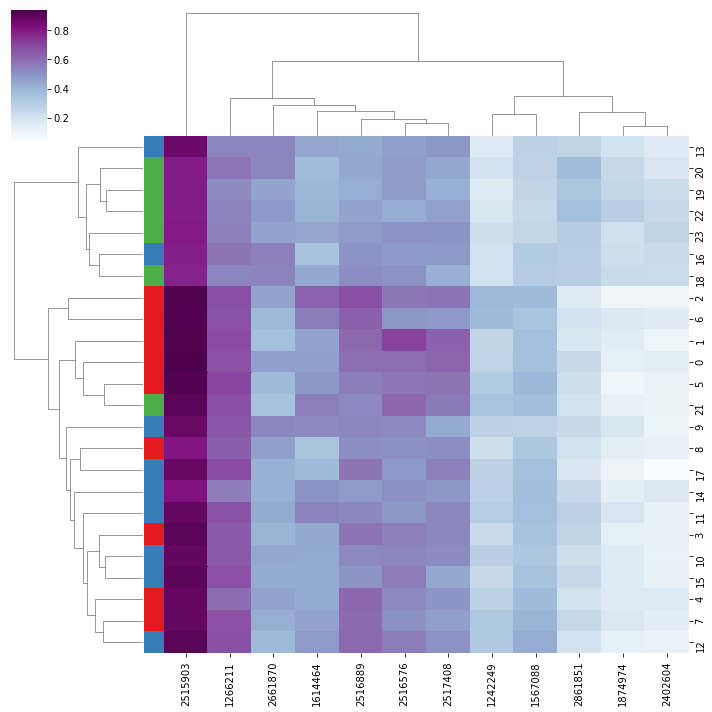

In [192]:
lut = dict(zip( df_gene_tp_all_info_mean.index.get_level_values('classt').drop_duplicates(), sns.color_palette("Set1", df_gene_tp_all_info_mean.index.get_level_values('classt').shape[0]).as_hex()[:]))


row_colors =df_gene_tp_all_info_mean.index.get_level_values('classt').map(lut)

lut = dict(zip( df_gene_tp_all_info_mean.index.get_level_values('group').drop_duplicates(), sns.color_palette("Set1", df_gene_tp_all_info_mean.index.get_level_values('group').shape[0]).as_hex()[:]))
row_colors2 =df_gene_tp_all_info_mean.index.get_level_values('group').map(lut)
sns.clustermap(df_gene_tp_all_info_mean.loc[:, all_bins_std[(all_bins_std >= 0.05) & (all_bins_mean >= 0.1)].index.tolist()].reset_index(drop=True), cmap="BuPu", col_cluster=True, robust=False, row_colors=[row_colors])


/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


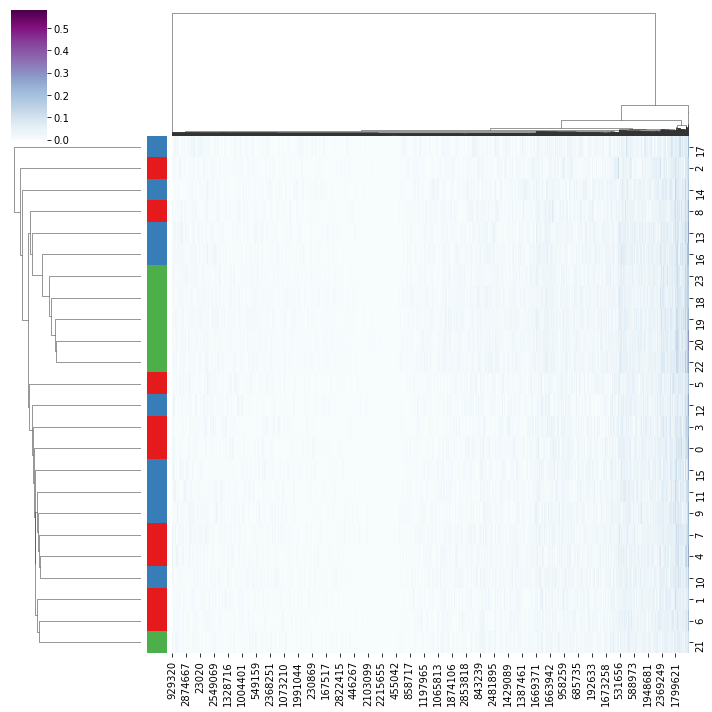

In [198]:
lut = dict(zip( df_gene_tp_all_info_mean.index.get_level_values('classt').drop_duplicates(), sns.color_palette("Set1", df_gene_tp_all_info_mean.index.get_level_values('classt').shape[0]).as_hex()[:]))


row_colors =df_gene_tp_all_info_mean.index.get_level_values('classt').map(lut)

lut = dict(zip( df_gene_tp_all_info_mean.index.get_level_values('group').drop_duplicates(), sns.color_palette("Set1", df_gene_tp_all_info_mean.index.get_level_values('group').shape[0]).as_hex()[:]))
row_colors2 =df_gene_tp_all_info_mean.index.get_level_values('group').map(lut)
sns.clustermap(df_gene_tp_all_info_mean.loc[:, bins_bed_cre[bins_bed_cre['cre'] >= 4]['bin_id'].tolist()].reset_index(drop=True), cmap="BuPu", col_cluster=True, robust=False, row_colors=[row_colors])



/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


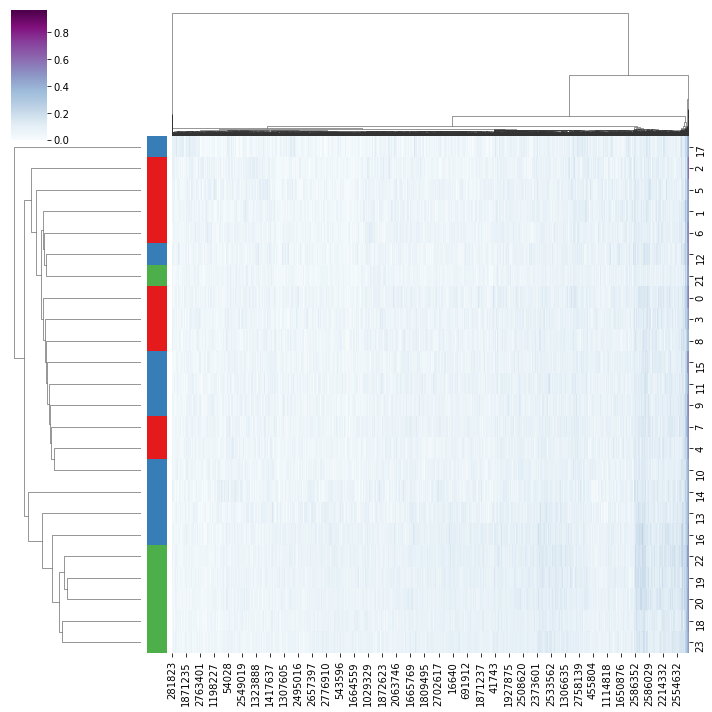

In [227]:
lut = dict(zip( df_gene_tp_all_info_mean.index.get_level_values('classt').drop_duplicates(), sns.color_palette("Set1", df_gene_tp_all_info_mean.index.get_level_values('classt').shape[0]).as_hex()[:]))


row_colors =df_gene_tp_all_info_mean.index.get_level_values('classt').map(lut)

lut = dict(zip( df_gene_tp_all_info_mean.index.get_level_values('group').drop_duplicates(), sns.color_palette("Set1", df_gene_tp_all_info_mean.index.get_level_values('group').shape[0]).as_hex()[:]))
row_colors2 =df_gene_tp_all_info_mean.index.get_level_values('group').map(lut)
sns.clustermap(df_gene_tp_all_info_mean.loc[:, gi].reset_index(drop=True), cmap="BuPu", col_cluster=True, robust=False, row_colors=[row_colors])


In [201]:
set(bins_bed_cre[bins_bed_cre['cre'] >= 4]['bin_id'].tolist()).intersection(set( all_bins_std[all_bins_std >= 0.05].index.tolist()))
                                                                                           
                                                                                           

set()

In [226]:
len(list(set.intersection(set(bins_bed_cre[bins_bed_cre['cre'] >= 1]['bin_id'].tolist()), (set( all_bins_std[all_bins_std >= 0.02].index.tolist()))) ))




6334

In [225]:
gi = list(set.intersection(set(bins_bed_cre[bins_bed_cre['cre'] >= 1]['bin_id'].tolist()), (set( all_bins_std[all_bins_std >= 0.02].index.tolist()))) )



In [182]:
df_gene_tp_all_info_mean.loc[:, all_bins_std[(all_bins_std >= 0.05) & (all_bins_mean >= 0.1)].index.tolist()].columns


Int64Index([1242249, 1266211, 1567088, 1614464, 1874974, 2402604, 2515903,
            2516576, 2516889, 2517408, 2661870, 2861851],
           dtype='int64')

In [178]:


    input_path=f'/grid/gillis/data/lohia/hi_c_data_processing/data_{species}/{SRP_name}/{resolution}/max/'
    bins_bede = pd.read_csv(f'{input_path}/all_bins.bed', names=['chr', 'start', 'end', 'bin_id'])
    bins_bede['bin_id'] = bins_bede.index
    #bins_bed['pos'] = bins_bed['chr'] + '_' + bins_bed['start'].astype('str')
    
    bins_bede.to_csv(f'{input_path}/all_bins_true.bed', index=False, header=False, sep='\t')

    os.system(f"~/.conda/envs/hicexplorer/bin/bedtools intersect -c -b /grid/gillis/data/lohia/hi_c_data_processing/data_human/aggregates/li2022/screen_v2/GRCh38-ccREs.bed -a /grid/gillis/data/lohia/hi_c_data_processing/data_{species}/{SRP_name}/{resolution}/max/all_bins_true.bed >  /grid/gillis/data/lohia/hi_c_data_processing/data_human/{SRP_name}/{resolution}/cre_intersect.bed")
    
    bins_bed_cre = pd.read_csv(f'/grid/gillis/data/lohia/hi_c_data_processing/data_human/{SRP_name}/{resolution}/cre_intersect.bed', names=['chr', 'start', 'end', 'bin_id', 'cre'], sep='\t')

In [183]:
bins_bed_cre[bins_bed_cre['bin_id'].isin([1242249, 1266211, 1567088, 1614464, 1874974, 2402604, 2515903,
            2516576, 2516889, 2517408, 2661870, 2861851])]

chr     start       end   bin_id  cre
1242249   chr7  10242000  10243000  1242249    0
1266211   chr7  34204000  34205000  1266211    0
1567088   chr9  30596000  30597000  1567088    0
1614464   chr9  77972000  77973000  1614464    0
1874974  chr11  66289000  66290000  1874974    3
2402604  chr16   2155000   2156000  2402604    2
2515903  chr17  25115000  25116000  2515903    0
2516576  chr17  25788000  25789000  2516576    0
2516889  chr17  26101000  26102000  2516889    0
2517408  chr17  26620000  26621000  2517408    0
2661870  chr19   7450000   7451000  2661870    1
2861851  chr22  37658000  37659000  2861851    3

In [164]:
df_gene_tp_all_info_mean.loc[:, all_bins_std[(all_bins_std >= 0.05) & (all_bins_mean >= 0.1)].index.tolist()].columns

Int64Index([1242249, 1266211, 1567088, 1614464, 1874974, 2402604, 2515903,
            2516576, 2516889, 2517408, 2661870, 2861851],
           dtype='int64')

In [ ]:
[2661870, 2402604, 1874974, 2861851, 1242249, 1266211, 1567088, 1614464,  2402604, 2515903, 2516576, 2516889, 2517408]

In [ ]:
ENSG00000271732

In [ ]:
266

In [161]:
cell_type_map = {'ITL23' : 'L2/3 IT' ,
'ITL4' : 'L4 IT' ,
'ITL5' : 'L5 IT' ,
'ITL6_1' : 'L6 IT' ,
'ITL6_2' : 'L6 IT CAR3' ,
'CT' : 'L6 CT' ,
'L6B' : 'L6B' ,
'NP' : 'L5/6 NP' ,
'ET' : 'L5 ET' ,
'SST_CHODL' : 'SST CHODL' ,
'SST' : 'SST' ,
'PVALB' : 'PVALB' ,
'PV_ChCs' : 'CHANDELIER' ,
'VIP' : 'VIP' ,
'SNCG' : 'SNCG' ,
'LAMP5' : 'LAMP5' ,
'LAMP5_LHX6' : 'LAMP5_LHX6' ,
'ASCT' : 'ASTRO' ,
'MGC' : 'MICRO-PVM' ,
'OPC' : 'OPC' ,
'OGC' : 'OLIGO' ,
'EC' : 'ENDO' ,
'Glutamatergic' : 'Glutamatergic',
'GABAergic' : 'GABAergic',
'Non-neuronal' : 'Non-neuronal'          
}

cell_type_map = {

'Glutamatergic' : 'Glutamatergic',
'GABAergic' : 'GABAergic',
'Non-neuronal' : 'Non-neuronal'          
}

class_map = {'ITL23' : 'Glutamatergic' ,
'ITL4' : 'Glutamatergic' ,
'ITL5' : 'Glutamatergic' ,
'ITL6_1' : 'Glutamatergic' ,
'ITL6_2' : 'Glutamatergic' ,
'CT' : 'Glutamatergic' ,
'L6B' : 'Glutamatergic' ,
'NP' : 'Glutamatergic' ,
'ET' : 'Glutamatergic' ,
'SST_CHODL' : 'GABAergic' ,
'SST' : 'GABAergic' ,
'PVALB' : 'GABAergic' ,
'PV_ChCs' : 'GABAergic' ,
'VIP' : 'GABAergic' ,
'SNCG' : 'GABAergic' ,
'LAMP5' : 'GABAergic' ,
'LAMP5_LHX6' : 'GABAergic' ,
'ASCT' : 'ASTRO' ,
'MGC' : 'Non-neuronal' ,
'OPC' : 'Non-neuronal' ,
'OGC' : 'Non-neuronal' ,
'EC' : 'Non-neuronal' , }

class_types = ['Glutamatergic', 'GABAergic', 'Non-neuronal']

input_path=f'/grid/gillis/data/lohia/hi_c_data_processing/data_human/{SRP_name}/{resolution}/max/'
bins_bed = pd.read_csv(f'{input_path}/all_bins.bed', names=['chr', 'start', 'end', 'bin_id'])
bins_bed['bin_id'] = bins_bed.index
bins_bed['pos'] = bins_bed['chr'] + '_' + bins_bed['start'].astype('str')

df_cre = pd.read_csv('/grid/gillis/data/lohia/hi_c_data_processing/data_human/aggregates/li2022/Table S6 – List of cCREs in bed format', sep='\t', names=['chr', 'start', 'end', 'cCRE_name'])
#df_cre = df_cre[df_cre['chr'].isin(chr_list)]
df_cre['start_bin'] = df_cre['start']/1000
df_cre['start_bin'] = df_cre['start_bin'].astype('int')
df_cre['start_bin'] = df_cre['start_bin']*1000
df_cre['start_bin'] = df_cre['start_bin'].astype('str')
df_cre['start_bin'] = df_cre['chr'] + '_' + df_cre['start_bin']
#df_cre_1kb = df_cre.drop_duplicates(subset=['start_bin'])

df_cre_1kb = df_cre.merge(bins_bed, left_on='start_bin', right_on='pos')

df_exp_list = []

for key in cell_type_map:

    df_exp = pd.read_csv(f'/grid/gillis/data/lohia/hi_c_data_processing/data_human/aggregates/li2022/{key}.txt', names=['cCRE_name'])

    df_exp = df_exp.merge(df_cre_1kb)[['bin_id']]

    df_exp['tp'] = 1
    
    df_exp = df_exp.groupby(['bin_id'])['tp'].sum().reset_index()
    
    print (df_exp)

    df_exp['tp'] = df_exp['tp']/df_exp['tp'].max()
    
    #df_exp = df_exp.drop_duplicates(subset=['bin_id'])

    df_exp = df_exp.set_index('bin_id').T
    
    df_exp['group'] = cell_type_map[key].lower()
    
    df_exp_list.append(df_exp)


df_exp_tp = pd.concat(df_exp_list)

df_exp_tp = df_exp_tp.fillna(0)


         bin_id  tp
0             9  50
1           180  60
2           191  55
3           267  37
4           585  28
...         ...  ..
487807  2874850  36
487808  2874855  38
487809  2874976  62
487810  2874978  27
487811  2875000  38

[487812 rows x 2 columns]
         bin_id  tp
0             9  41
1           180  52
2           191  56
3           267  32
4           585  24
...         ...  ..
487808  2874850  32
487809  2874855  32
487810  2874976  56
487811  2874978  24
487812  2875000  32

[487813 rows x 2 columns]
         bin_id  tp
0             9  34
1           180  41
2           191  41
3           267  27
4           585  21
...         ...  ..
487815  2874850  24
487816  2874855  24
487817  2874976  41
487818  2874978  19
487819  2875000  29

[487820 rows x 2 columns]


In [190]:
df_exp_tp.columns.intersection([2661870, 2402604, 1874974, 2861851, 1242249, 1266211, 1567088, 1614464,  2402604, 2515903, 2516576, 2516889, 2517408])



Index([2402604, 2861851], dtype='object', name='bin_id')

In [ ]:
[ 2402604, 1874974, 2861851, 1242249, 1266211, 1567088, 1614464,  2402604, 2515903, 2516576, 2516889, 2517408]

In [177]:
marker_list['ENSG00000271732']

KeyError: 'ENSG00000271732'

In [191]:
df_exp_tp[[2402604, 2861851]]

bin_id   2402604   2861851
tp      0.492063  0.968254
tp      0.500000  0.973214
tp      0.488095  0.976190

In [45]:


    input_path=f'/grid/gillis/data/lohia/hi_c_data_processing/data_{species}/{SRP_name}/{resolution}/max/'
    bins_bed = pd.read_csv(f'{input_path}/all_bins.bed', names=['chr', 'start', 'end', 'bin_id'])
    bins_bed['bin_id'] = bins_bed.index
    #bins_bed['pos'] = bins_bed['chr'] + '_' + bins_bed['start'].astype('str')
    
    bins_bed.to_csv(f'{input_path}/all_bins_true.bed', index=False, header=False, sep='\t')

    os.system(f"~/.conda/envs/hicexplorer/bin/bedtools intersect -c -b /grid/gillis/data/lohia/hi_c_data_processing/data_human/aggregates/li2022/screen_v2/GRCh38-ccREs.bed -a /grid/gillis/data/lohia/hi_c_data_processing/data_{species}/{SRP_name}/{resolution}/max/all_bins_true.bed >  /grid/gillis/data/lohia/hi_c_data_processing/data_human/{SRP_name}/{resolution}/cre_intersect.bed")
    
    bins_bed_cre = pd.read_csv(f'/grid/gillis/data/lohia/hi_c_data_processing/data_human/{SRP_name}/{resolution}/cre_intersect.bed', names=['chr', 'start', 'end', 'bin_id', 'cre'], sep='\t')

In [ ]:
df_prior = pd.read_csv(f'/grid/gillis/data/lohia/hi_c_data_processing/data_{species}/{SRP_name}/{resolution}/max/contact_top1/totg_reg_prior_only_top1_inter.csv', sep='\t')
#del_al = int(df_prior.shape[0]*no_of_high_bins/100)
given_bins = df_prior.sort_values(by=['prior_val']).tail(86276)['bin_id'].tolist()
        

In [41]:
from umap import UMAP
import plotly.express as px
from sklearn.preprocessing import StandardScaler



#features = df.loc[:, :2875001]
#features = df_gene_tp.loc[:, :]
#features = df_gene_tp.loc[:, bins_bed_cre[bins_bed_cre['cre'] >= 3]['bin_id'].tolist()]
features = df_gene_tp_all_info_mean.loc[:, all_bins_std[all_bins_std >= 0.04].index.tolist()]

features_sc =  StandardScaler().fit_transform(features)


umap_2d = UMAP(n_components=2, init='random', random_state=0)


proj_2d = umap_2d.fit_transform(features_sc)

In [42]:
fig_2d = px.scatter(
    proj_2d, x=0, y=1,
    color=df_gene_tp_all_info_mean.index.get_level_values('classt'), labels={'color': 'classt'}
)


fig_2d.show()



In [202]:
all_bins_std.max()

0.16202285885810852

In [203]:
all_bins_std

0          0.0
1          0.0
2          0.0
3          0.0
4          0.0
          ... 
2875007    0.0
2875008    0.0
2875009    0.0
2875010    0.0
2875011    0.0
Length: 2875012, dtype: float32

In [ ]:
lut = dict(zip( df_gene_tp_all_info_mean.index.get_level_values('classt').drop_duplicates(), sns.color_palette("Set1", df_gene_tp_all_info_mean.index.get_level_values('classt').shape[0]).as_hex()[:]))


row_colors =df_gene_tp_all_info_mean.index.get_level_values('classt').map(lut)
sns.clustermap(df_gene_tp_all_info_mean.loc[:, all_bins_std[all_bins_std >= 0.05].index.tolist()].reset_index(drop=True), cmap="BuPu", col_cluster=True, robust=False, row_colors=row_colors)


/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/seaborn/matrix.py:654: UserWarning:

Clustering large matrix with scipy. Installing `fastcluster` may give better performance.



In [198]:
df_gene_tp_all_info_mean.max().max()

1.0

In [158]:


    input_path=f'/grid/gillis/data/lohia/hi_c_data_processing/data_{species}/{SRP_name}/{resolution}/max/'
    bins_bed = pd.read_csv(f'{input_path}/all_bins.bed', names=['chr', 'start', 'end', 'bin_id'])
    bins_bed['bin_id'] = bins_bed.index
    #bins_bed['pos'] = bins_bed['chr'] + '_' + bins_bed['start'].astype('str')
    
    bins_bed.to_csv(f'{input_path}/all_bins_true.bed', index=False, header=False, sep='\t')

    os.system(f"~/.conda/envs/hicexplorer/bin/bedtools intersect -c -b /grid/gillis/data/lohia/hi_c_data_processing/data_human/aggregates/li2022/screen_v2/GRCh38-ccREs.bed -a /grid/gillis/data/lohia/hi_c_data_processing/data_{species}/{SRP_name}/{resolution}/max/all_bins_true.bed >  /grid/gillis/data/lohia/hi_c_data_processing/data_human/{SRP_name}/{resolution}/cre_intersect.bed")
    
    bins_bed_cre = pd.read_csv(f'/grid/gillis/data/lohia/hi_c_data_processing/data_human/{SRP_name}/{resolution}/cre_intersect.bed', names=['chr', 'start', 'end', 'bin_id', 'cre'], sep='\t')

In [159]:
from umap import UMAP
import plotly.express as px




#features = df.loc[:, :2875001]
features = df_gene_tp.loc[:, bins_bed_cre[bins_bed_cre['cre'] >= 3]['bin_id'].tolist()]


umap_2d = UMAP(n_components=2, init='random', random_state=0)


proj_2d = umap_2d.fit_transform(features)

In [162]:
fig_2d = px.scatter(
    proj_2d, x=0, y=1,
    color=marker_list.group, labels={'color': 'classt'}, color_discrete_sequence=sns.color_palette("Spectral", df_proj_2d.group.drop_duplicates().shape[0]).as_hex()[:]
)


fig_2d.show()

In [134]:
df_prior = pd.read_csv(f'/grid/gillis/data/lohia/hi_c_data_processing/data_{species}/{SRP_name}/{resolution}/max/contact_top1/totg_reg_prior_only_top1_inter.csv', sep='\t')
#del_al = int(df_prior.shape[0]*no_of_high_bins/100)
given_bins = df_prior.sort_values(by=['prior_val']).tail(86276)['bin_id'].tolist()
        

In [135]:
from umap import UMAP
import plotly.express as px




#features = df.loc[:, :2875001]
features = df_gene_tp.loc[:, given_bins]


umap_2d = UMAP(n_components=2, init='random', random_state=0)


proj_2d = umap_2d.fit_transform(features)


In [140]:
fig_2d = px.scatter(
    proj_2d, x=0, y=1,
    color=marker_list.cell_type, labels={'color': 'cell_type'}
)


fig_2d.show()

In [43]:
fig_2d = px.scatter(
    proj_2d, x=0, y=1,
    color=marker_list.classt, labels={'color': 'classt'}
)


fig_2d.show()

In [53]:
fig_2d = px.scatter(
    proj_2d, x=0, y=1,
    color=marker_list.group, labels={'color': 'group'}
)


fig_2d.show()

In [121]:
sns.color_palette("Paired", df_proj_2d.group.drop_duplicates().shape[0]).as_hex()[:]

['#a6cee3',
 '#1f78b4',
 '#b2df8a',
 '#33a02c',
 '#fb9a99',
 '#e31a1c',
 '#fdbf6f',
 '#ff7f00',
 '#cab2d6',
 '#6a3d9a',
 '#ffff99',
 '#b15928',
 '#a6cee3',
 '#1f78b4',
 '#b2df8a',
 '#33a02c',
 '#fb9a99',
 '#e31a1c',
 '#fdbf6f',
 '#ff7f00',
 '#cab2d6',
 '#6a3d9a',
 '#ffff99',
 '#b15928']

In [124]:
fig_2d = px.scatter(
    proj_2d, x=0, y=1,
    color=marker_list.group, labels={'color': 'group'}, color_discrete_sequence=sns.color_palette("Spectral", df_proj_2d.group.drop_duplicates().shape[0]).as_hex()[:]
)


fig_2d.show()



In [129]:
marker_list.group.head()

0    L6 CT
1    L6 CT
2    L6 CT
3    L6 CT
4    L6 CT
Name: group, dtype: object

In [127]:
fig_2d = px.scatter(
     x=df_proj_2d[0], y=df_proj_2d[1],
    color=df_proj_2d.group, labels={'color': 'group'}, color_discrete_sequence=sns.color_palette("Spectral", df_proj_2d.group.drop_duplicates().shape[0]).as_hex()[:]
)


fig_2d.show()


/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



ValueError: 'color' kwarg must be an color or sequence of color specs.  For a sequence of values to be color-mapped, use the 'c' argument instead.

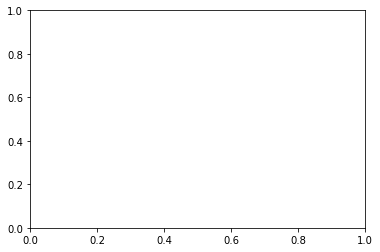

In [58]:
sns.scatterplot(proj_2d[:,0],proj_2d[:,1] , color=marker_list.group)

In [59]:
df_proj_2d= pd.DataFrame(proj_2d)

In [61]:
df_proj_2d['group'] = marker_list.group

In [62]:
df_proj_2d['cell_type'] = marker_list.cell_type

In [63]:
df_proj_2d['classt'] = marker_list.classt

In [72]:
df_proj_2d = df_proj_2d.sort_values(by=['classt', 'group', 'cell_type'])

/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



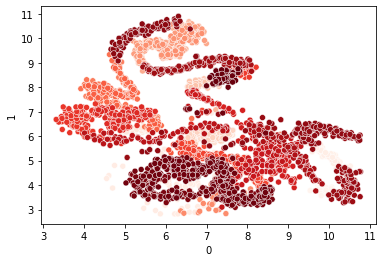

In [79]:
ax = sns.scatterplot(df_proj_2d[0], df_proj_2d[1] , hue=df_proj_2d.cell_type, legend=False, palette="Reds")

/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



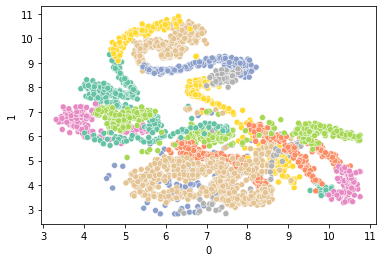

In [109]:
ax = sns.scatterplot(df_proj_2d[0], df_proj_2d[1] , hue=df_proj_2d.group, legend=False, palette=sns.color_palette("Set2", df_proj_2d.group.drop_duplicates().shape[0]))


In [111]:
color_palette("Set2", df_proj_2d.group.drop_duplicates().shape[0])

NameError: name 'color_palette' is not defined

/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



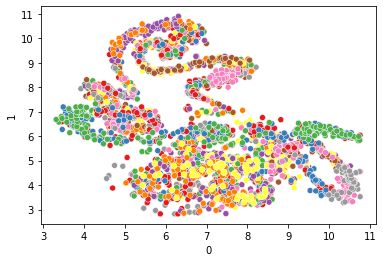

In [107]:
ax = sns.scatterplot(df_proj_2d[0], df_proj_2d[1] , hue=df_proj_2d.cell_type, legend=False, palette=sns.color_palette("Set1", df_proj_2d.cell_type.drop_duplicates().shape[0]))


In [98]:
df_proj_2d.group.drop_duplicates().shape[0]

24

In [83]:
sns.color_palette("hls", 20)

[(0.86, 0.3712, 0.33999999999999997),
 (0.86, 0.5272, 0.33999999999999997),
 (0.86, 0.6832, 0.33999999999999997),
 (0.86, 0.8392000000000002, 0.33999999999999997),
 (0.7247999999999999, 0.86, 0.33999999999999997),
 (0.5688000000000001, 0.86, 0.33999999999999997),
 (0.41279999999999994, 0.86, 0.33999999999999997),
 (0.33999999999999997, 0.86, 0.42320000000000013),
 (0.33999999999999997, 0.86, 0.5792000000000002),
 (0.33999999999999997, 0.86, 0.7352000000000001),
 (0.33999999999999997, 0.8287999999999999, 0.86),
 (0.33999999999999997, 0.6727999999999997, 0.86),
 (0.33999999999999997, 0.5167999999999995, 0.86),
 (0.33999999999999997, 0.36079999999999973, 0.86),
 (0.4752000000000003, 0.33999999999999997, 0.86),
 (0.6311999999999998, 0.33999999999999997, 0.86),
 (0.7871999999999999, 0.33999999999999997, 0.86),
 (0.86, 0.33999999999999997, 0.7767999999999993),
 (0.86, 0.33999999999999997, 0.6207999999999999),
 (0.86, 0.33999999999999997, 0.46479999999999977)]

In [84]:
sns.color_palette("Paired", 20)

[(0.6509803921568628, 0.807843137254902, 0.8901960784313725),
 (0.12156862745098039, 0.47058823529411764, 0.7058823529411765),
 (0.6980392156862745, 0.8745098039215686, 0.5411764705882353),
 (0.2, 0.6274509803921569, 0.17254901960784313),
 (0.984313725490196, 0.6039215686274509, 0.6),
 (0.8901960784313725, 0.10196078431372549, 0.10980392156862745),
 (0.9921568627450981, 0.7490196078431373, 0.43529411764705883),
 (1.0, 0.4980392156862745, 0.0),
 (0.792156862745098, 0.6980392156862745, 0.8392156862745098),
 (0.41568627450980394, 0.23921568627450981, 0.6039215686274509),
 (1.0, 1.0, 0.6),
 (0.6941176470588235, 0.34901960784313724, 0.1568627450980392),
 (0.6509803921568628, 0.807843137254902, 0.8901960784313725),
 (0.12156862745098039, 0.47058823529411764, 0.7058823529411765),
 (0.6980392156862745, 0.8745098039215686, 0.5411764705882353),
 (0.2, 0.6274509803921569, 0.17254901960784313),
 (0.984313725490196, 0.6039215686274509, 0.6),
 (0.8901960784313725, 0.10196078431372549, 0.10980392156862745),
 (0.9921568627450981, 0.7490196078431373, 0.43529411764705883),
 (1.0, 0.4980392156862745, 0.0)]

In [118]:
sns.color_palette("Set2",20).as_hex()[:]

['#66c2a5',
 '#fc8d62',
 '#8da0cb',
 '#e78ac3',
 '#a6d854',
 '#ffd92f',
 '#e5c494',
 '#b3b3b3',
 '#66c2a5',
 '#fc8d62',
 '#8da0cb',
 '#e78ac3',
 '#a6d854',
 '#ffd92f',
 '#e5c494',
 '#b3b3b3',
 '#66c2a5',
 '#fc8d62',
 '#8da0cb',
 '#e78ac3']

In [113]:
y = sns.color_palette("Set2",20)

In [116]:
y.as_hex()[:]

['#66c2a5',
 '#fc8d62',
 '#8da0cb',
 '#e78ac3',
 '#a6d854',
 '#ffd92f',
 '#e5c494',
 '#b3b3b3',
 '#66c2a5',
 '#fc8d62',
 '#8da0cb',
 '#e78ac3',
 '#a6d854',
 '#ffd92f',
 '#e5c494',
 '#b3b3b3',
 '#66c2a5',
 '#fc8d62',
 '#8da0cb',
 '#e78ac3']